In [38]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology
from skimage.morphology import opening
from skimage import filters
from functools import partial 
import pandas as pd
from os import listdir
import os
from os.path import isfile, join
import fyp2021p3_group00_functions as util
import seaborn as sns

import cv2, numpy as np
from sklearn.cluster import KMeans


from matplotlib import rcParams

from PIL import Image

import warnings

# Read in only files with Keratosis

In [5]:
# Task 2
# - What do you expect from these values for a perfect circle?

# Load csv file, get filenames for 
ground_truth = pd.read_csv("../data/example_ground_truth.csv")
picTypes = pd.read_csv("../data/example_ground_truth.csv", sep = ",")
#display(picTypes)

mask = picTypes["seborrheic_keratosis"] == 1
keratosis = picTypes[mask]

#display(keratosis)
keratosis_files = keratosis["image_id"].sort_values()

features = pd.read_csv("../features/features.csv")

#display(keratosis_files)

# Make a dataset for healthy and non-healthy

In [6]:
is_melanoma = (ground_truth['melanoma'] == 1)
melanoma = ground_truth[is_melanoma]
len(melanoma)

30

In [7]:
is_keratosis = (ground_truth['seborrheic_keratosis'] == 1)
keratosis = ground_truth[is_keratosis]
len(keratosis)

42

In [8]:
healthy = ((ground_truth['melanoma'] == 0) & (ground_truth['seborrheic_keratosis'] == 0))
healthy = ground_truth[healthy]
len(healthy)

78

In [9]:
melanoma_IDs = melanoma["image_id"]
keratosis_IDs = keratosis["image_id"]
healthy_IDs = healthy["image_id"]

In [10]:
df = pd.DataFrame(features)

typet = []
for i in df['id']:
    for m in melanoma_IDs:                
            if i == m:
                typet.append('melanoma')
                      
for x in df['id']:
    for k in keratosis_IDs:
        if x == k:
            typet.append('keratosis')
                      
for y in df['id']:
    for h in healthy_IDs:
        if y == h:
            typet.append('healthy')
            
df['type'] = typet           
df.to_csv('../features/types.csv', index=False)

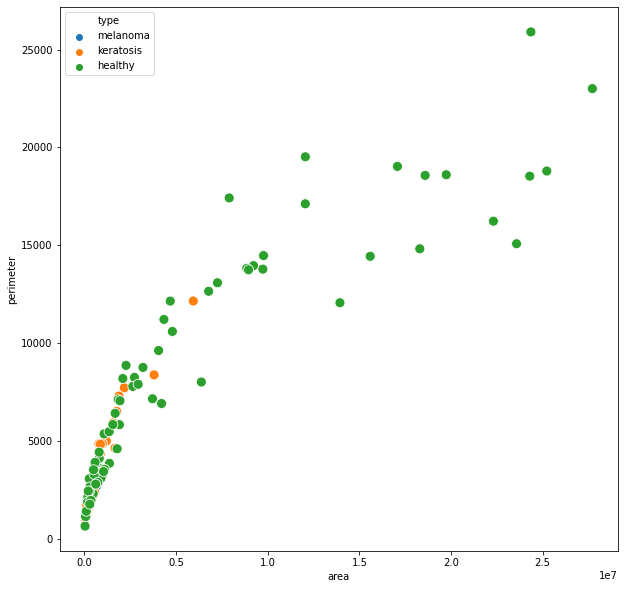

In [11]:
rcParams['figure.figsize'] = 10,10
sns.scatterplot(data=df, x="area", y="perimeter", hue="type", s=100);

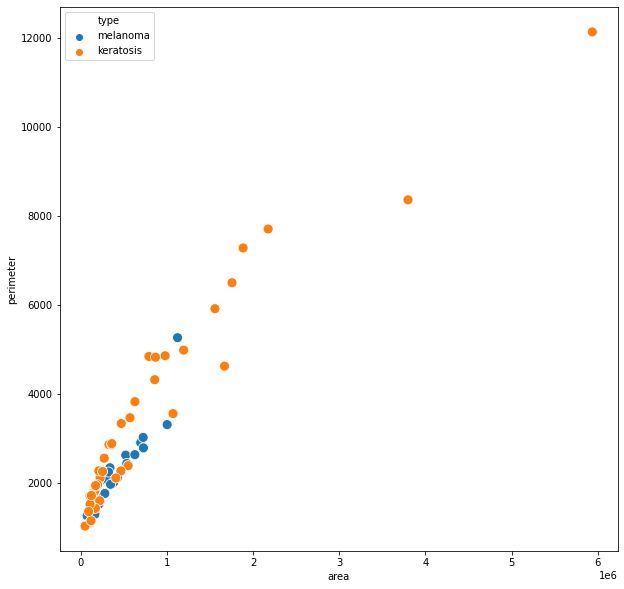

In [12]:
# filter out healthy and plot it again
#display(df)
mask = df["type"] != "healthy"
df_ill = df[mask]
#display(df_ill)
rcParams['figure.figsize'] = 10,10
sns.scatterplot(data=df_ill, x="area", y="perimeter", hue="type", s=100);

# Search the 4 most dominant color of each picture

Loop through a 25% smaller pictures. Code makes a pandas dataframe with 5 - 5 column (RGB code in string than occurance in %) \n
Since a mask is black further calculation will be applied (delete the occurance the black than divide the occurance between the remains

In [189]:
#pics = pd.read_csv("../data/dummy_ground_truth.csv", sep = ",")
pics = pd.read_csv("../data/example_ground_truth.csv", sep = ",")
display(pics)

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0
...,...,...,...
145,ISIC_0015443,0.0,0.0
146,ISIC_0015445,0.0,0.0
147,ISIC_0015483,0.0,0.0
148,ISIC_0015496,0.0,0.0


Define the functions for the read in

In [ ]:
# this code append the rgb values into a pandas dataframe

def color_normalizer(arr, name):
    #print("function")
    #print(arr)
    counter = 1
    for (percent, color) in arr:
        #print("picture is ",name,"  round ",counter)
        c1 = int(color[0])
        c2 = int(color[1])
        c3 = int(color[2])
        #print("colors are\n")
        #print(c1,"",c2,"",c3)
        #print(percent)
        #print(name)
        index = pics[pics['image_id'] == name].index.values
        rowIndex = pics.index[index]
        rgb_str = str(c1) + "," + str(c2) + "," + str(c3)
        #print("this will be the rgb_str\n")
        #print(rgb_str)
        pics.loc[rowIndex, 'colorRGB_'+str(counter)] = rgb_str
        pics.loc[rowIndex, 'occurence_of_colour_percent_'+str(counter)] = percent*100
        #pics.loc[rowIndex, 'trial'] = color
        #pics[name] = color
        counter = counter + 1
    None

In [ ]:
def dominant_colors(cluster, centroids, name):
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    #print(hist)
    hist /= hist.sum()
    # Create frequency rect and iterate through each cluster's color and percentage
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    start = 0
    color_normalizer(colors, name) 
    for (percent, color) in colors:
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), \
                      color.astype("uint8").tolist(), -1)
        start = end
    return rect

In [52]:
# function to rgb color to html color
def clamp(x): 
  return max(0, min(x, 255))

This is the function which go through the pics

## Show and save it

In [76]:
WARN = input("This operation takes several minutes, the raw dataset is already exist. Do you wish to continue: (Yes/No) ")

if WARN.lower().startswith("y"):
    print("\n---It takes time --- \n")
    for i in pics["image_id"]:
        #print(i)
        # Alternative: replace the non-lesion pixels
        im = plt.imread('../data/example_image/sm/'+i+'.jpg')
        #plt.imshow(im)
        img2 = im.copy()
        mask=plt.imread('../data/example_segmentation/sm/'+i+'_segmentation.png')
        img2[mask==0] = 0
        #plt.imshow(img2)
        image = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        reshape = img2.reshape((img2.shape[0] * img2.shape[1], 3))
        # Find and display most dominant colors
        cluster = KMeans(n_clusters=5).fit(reshape)
        visualize = dominant_colors(cluster, cluster.cluster_centers_, i)
    display(pics)
    pics.to_csv('../data/processed/dominant_colors_raw.csv')
else:
    print("Cancelled operation")

This operation takes several minutes, the raw dataset is already exist. Do you wish to continue: (Yes/No) no
Cancelled operation


In [9]:
pics_to_process = pd.read_csv("../data/processed/dominant_colors_raw.csv", sep = ",")

In [10]:
# highest element check, also for a good masks
for i in range(len(pics_to_process["image_id"])):
    txt = pics_to_process["colorRGB_5"][i]
    x = txt.split(",")
    #print(pics_to_process["image_id"][i]," ",x)
no_adjsutment_examples_column_5 = ["ISIC_0009995","ISIC_0014688","ISIC_0014712","ISIC_0014937","ISIC_0015062","ISIC_0015256","ISIC_0015372"]

## Delete max values if they are the black areas and adjust the remain 4 dominant colors

In [11]:
for i in range(len(pics_to_process["image_id"])):
    txt = pics_to_process["colorRGB_5"][i]
    x = txt.split(",")
    sumy = 0
    for y in range(len(x)):
        sumy = sumy + int(x[y])
    if sumy > 0:
        print(pics_to_process["image_id"][i]," ",x)
        #im = plt.imread('../data/example_image/sm/'+pics_to_process["image_id"][i]+'.jpg')
        #plt.imshow(im)
no_adjsutment_examples_column_5 = ["ISIC_0009995","ISIC_0014688","ISIC_0014712","ISIC_0014937","ISIC_0015062","ISIC_0015256","ISIC_0015372"]

ISIC_0009995   ['164', '137', '104']
ISIC_0014688   ['171', '119', '83']
ISIC_0014712   ['115', '92', '87']
ISIC_0014937   ['155', '98', '74']
ISIC_0015062   ['119', '90', '96']
ISIC_0015256   ['201', '110', '89']
ISIC_0015372   ['71', '30', '33']


In [12]:
# rearrange the non-black colours in column 5 
for i in range(len(pics_to_process["image_id"])):
    pic_id = pics_to_process["image_id"][i]
    if any(t == pic_id for t in no_adjsutment_examples_column_5):
        index = pics_to_process[pics_to_process['image_id'] == pic_id].index.values
        rowIndex = pics_to_process.index[index]
        pics_to_process.loc[rowIndex, 'adjusted_bool'] = 0
        #print("no")
    else:
        index = pics_to_process[pics_to_process['image_id'] == pic_id].index.values
        rowIndex = pics_to_process.index[index]
        pics_to_process.loc[rowIndex, 'adjusted_bool'] = 1
        remains = 100 - pics_to_process["occurence_of_colour_percent_5"][i]
        #print(remains)
        for i in range(1,4+1):
            #print(i)
            new_occ_percent = (100/remains)*pics_to_process['occurence_of_colour_percent_'+str(i)]        
            pics_to_process.loc[rowIndex, 'adjusted_percent'+str(1+i)] = new_occ_percent
            None

In [18]:
#display(pics_to_process)
pics_to_process.to_csv('../data/processed/dominant_colors_adjusted.csv')

,Unnamed: 0,image_id,melanoma,seborrheic_keratosis,colorRGB_1,occurence_of_colour_percent_1,colorRGB_2,occurence_of_colour_percent_2,colorRGB_3,occurence_of_colour_percent_3,colorRGB_4,occurence_of_colour_percent_4,colorRGB_5,occurence_of_colour_percent_5,adjusted_bool,adjusted_percent2,adjusted_percent3,adjusted_percent4,adjusted_percent5
0,0,ISIC_0001769,0.0,0.0,"180,131,103",0.592614,"170,111,78",0.877635,"147,78,47",0.962407,"159,93,61",1.185227,"0,0,0",96.382118,1.0,16.380123,24.258252,26.601378,32.760247
1,1,ISIC_0001852,0.0,0.0,"144,79,44",0.333575,"163,109,80",0.424908,"120,49,23",0.434881,"87,27,15",0.989439,"0,0,0",97.817198,1.0,15.281953,19.466154,19.923049,45.328845
2,2,ISIC_0001871,0.0,0.0,"171,115,75",0.517553,"184,138,106",0.865300,"189,151,129",0.926188,"179,127,91",1.109116,"0,0,0",96.581843,1.0,15.141278,25.314803,27.096130,32.447789
3,3,ISIC_0003462,0.0,0.0,"162,105,69",0.496557,"172,128,100",0.530413,"180,150,132",0.823570,"149,84,48",0.843779,"0,0,0",97.305682,1.0,18.429768,19.686343,30.566920,31.316969
4,4,ISIC_0003539,0.0,0.0,"113,36,17",0.636968,"152,72,32",1.137461,"173,106,64",1.339548,"182,129,93",2.154720,"0,0,0",94.731303,1.0,12.089664,21.589041,25.424658,40.896638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,145,ISIC_0015443,0.0,0.0,"160,118,103",6.591019,"121,59,26",7.037686,"133,81,52",9.709752,"144,98,75",10.261873,"0,0,0",66.399669,1.0,19.615936,20.945288,28.897787,30.540989
146,146,ISIC_0015445,0.0,0.0,"88,28,20",8.018995,"216,141,128",9.435960,"130,73,64",9.901824,"171,110,100",13.303647,"0,0,0",59.339575,1.0,19.721867,23.206742,24.352484,32.718908
147,147,ISIC_0015483,0.0,0.0,"87,54,42",5.216966,"189,147,131",7.181129,"124,90,77",8.236541,"156,120,106",8.949026,"0,0,0",70.416338,1.0,17.634617,24.273969,27.841520,30.249894
148,148,ISIC_0015496,0.0,0.0,"154,75,51",6.033107,"71,27,16",7.425387,"216,116,91",8.003143,"243,169,144",8.147864,"0,0,0",70.390499,1.0,20.375577,25.077717,27.028971,27.517735


In [177]:
# final daztaset about dominant colours
# it gives back lot of errors, bnut still functional
pics_raw = pd.read_csv("../data/processed/dominant_colors_adjusted.csv", sep = ",")
pics_raw.reset_index()
pics_raw["RGB1"] = 0
pics_raw["RGB2"] = 0
pics_raw["RGB3"] = 0
pics_raw["RGB4"] = 0
pics_raw["RGB1_occ"] = 0
pics_raw["RGB2_occ"] = 0
pics_raw["RGB3_occ"] = 0
pics_raw["RGB4_occ"] = 0
for i in range(len(pics_raw["image_id"])):
    if pics_raw["adjusted_bool"][i] == 1:
        t = pics_raw["colorRGB_1"][i]
        pics_raw["RGB1"][i] = t
        pics_raw["RGB2"][i] = pics_raw["colorRGB_2"][i]
        pics_raw["RGB3"][i] = pics_raw["colorRGB_3"][i]
        pics_raw["RGB4"][i] = pics_raw["colorRGB_4"][i]
        pics_raw["RGB1_occ"][i] = pics_raw["adjusted_percent2"][i]
        pics_raw["RGB2_occ"][i] = pics_raw["adjusted_percent3"][i]
        pics_raw["RGB3_occ"][i] = pics_raw["adjusted_percent4"][i]
        pics_raw["RGB4_occ"][i] = pics_raw["adjusted_percent5"][i]
    else:
        pics_raw["RGB1"][i] = pics_raw["colorRGB_2"][i]
        pics_raw["RGB2"][i] = pics_raw["colorRGB_3"][i]
        pics_raw["RGB3"][i] = pics_raw["colorRGB_4"][i]
        pics_raw["RGB4"][i] = pics_raw["colorRGB_5"][i]
        pics_raw["RGB1_occ"][i] = pics_raw["occurence_of_colour_percent_2"][i]
        pics_raw["RGB2_occ"][i] = pics_raw["occurence_of_colour_percent_3"][i]
        pics_raw["RGB3_occ"][i] = pics_raw["occurence_of_colour_percent_4"][i]
        pics_raw["RGB4_occ"][i] = pics_raw["occurence_of_colour_percent_5"][i]
        
pics_raw = pics_raw.drop(['colorRGB_1','colorRGB_2','colorRGB_3','colorRGB_4','colorRGB_5'],axis=1)
pics_raw = pics_raw.drop(['occurence_of_colour_percent_1','occurence_of_colour_percent_2','occurence_of_colour_percent_3','occurence_of_colour_percent_4','occurence_of_colour_percent_5'],axis=1)
pics_raw = pics_raw.drop(['adjusted_percent2','adjusted_percent3','adjusted_percent4','adjusted_percent5'],axis=1)

# convert RGB codes into HTML codes

# convert RGB to html colors
color_list =["RGB1","RGB2","RGB3","RGB4"]
for i in color_list:
    pics_raw[i+"html"] = 0
leng = len(dominant_color)
for y in color_list:
    for i,t in zip(range(leng),dominant_color[y]):
        x = t.split(",")
        c1,c2,c3 = int(x[0]),int(x[1]),int(x[2])
        v = "#{0:02x}{1:02x}{2:02x}".format(clamp(c1), clamp(c2), clamp(c3))
        pics_raw[y+"html"][i] = v
        #print(v)
        
pics_raw["help_int_for_colors"] = 0
for i in range(len(pics_raw)):
    if pics_raw["melanoma"][i] == 1:
        pics_raw["help_int_for_colors"][i] = "melanoma"
    elif pics_raw["seborrheic_keratosis"][i] == 1:
        pics_raw["help_int_for_colors"][i] = "keratosis"
    else:
        pics_raw["help_int_for_colors"][i] = "healthy"

pics_raw.to_csv('../data/processed/dominant_colors_final_dataset.csv')

In [179]:
# 
final_df

,image_id,melanoma,seborrheic_keratosis,RGB1,RGB2,RGB3,RGB4,RGB1_occ,RGB2_occ,RGB3_occ,RGB4_occ,RGB1html,RGB2html,RGB3html,RGB4html,help_int_for_colors,border_diff_percent,rotation_amount_deg,area,perimeter
0,ISIC_0001769,0.0,0.0,"180,131,103","170,111,78","147,78,47","159,93,61",16,24,26,32,#b48367,#aa6f4e,#934e2f,#9f5d3d,healthy,60.366446,70,216160.0,2013.0
1,ISIC_0001852,0.0,0.0,"144,79,44","163,109,80","120,49,23","87,27,15",15,19,19,45,#904f2c,#a36d50,#783117,#571b0f,healthy,31.599922,90,130493.0,1372.0
2,ISIC_0001871,0.0,0.0,"171,115,75","184,138,106","189,151,129","179,127,91",15,25,27,32,#ab734b,#b88a6a,#bd9781,#b37f5b,healthy,48.707232,120,205116.0,1720.0
3,ISIC_0003462,0.0,0.0,"162,105,69","172,128,100","180,150,132","149,84,48",18,19,30,31,#a26945,#ac8064,#b49684,#955430,healthy,31.444401,90,161705.0,1344.0
4,ISIC_0003539,0.0,0.0,"113,36,17","152,72,32","173,106,64","182,129,93",12,21,25,40,#712411,#984820,#ad6a40,#b6815d,healthy,64.507193,50,317040.0,2063.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,ISIC_0015443,0.0,0.0,"160,118,103","121,59,26","133,81,52","144,98,75",19,20,28,30,#a07667,#793b1a,#855134,#90624b,healthy,382.372667,130,9732988.0,13775.0
146,ISIC_0015445,0.0,0.0,"88,28,20","216,141,128","130,73,64","171,110,100",19,23,24,32,#581c14,#d88d80,#824940,#ab6e64,healthy,463.209565,90,12049938.0,19517.0
147,ISIC_0015483,0.0,0.0,"87,54,42","189,147,131","124,90,77","156,120,106",17,24,27,30,#57362a,#bd9383,#7c5a4d,#9c786a,healthy,366.120723,90,8856478.0,13813.0
148,ISIC_0015496,0.0,0.0,"154,75,51","71,27,16","216,116,91","243,169,144",20,25,27,27,#9a4b33,#471b10,#d8745b,#f3a990,healthy,416.412325,50,8951522.0,13742.0


## Merge datasets

In [178]:
dominant_color = pd.read_csv("../data/processed/dominant_colors_final_dataset.csv", sep = ",")
a_p = pd.read_csv("../features/features.csv", sep = ",")
border_symmetry = pd.read_csv("../data/processed/border_symmetry.csv", sep = ",")
border_symmetry = border_symmetry.drop(['image_id'],axis=1)
dominant_color = dominant_color.drop(['Unnamed: 0','Unnamed: 0.1','adjusted_bool'],axis=1)
final_df = pd.concat([dominant_color, border_symmetry,a_p], axis=1)
final_df = final_df.drop(['Unnamed: 0.1.1',"id"],axis=1)
final_df.to_csv('../data/processed/final_df.csv')

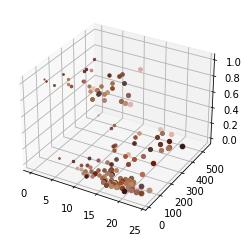

In [115]:
X = final_df["RGB1_occ"]
Y = final_df["border_diff_percent"]
Z = final_df["seborrheic_keratosis"]
colors=final_df["RGB1html"]

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')


for i in range(len(X)):
    ax.scatter(X[i], Y[i], Z[i], s = X[i], color=colors[i])
plt.show()

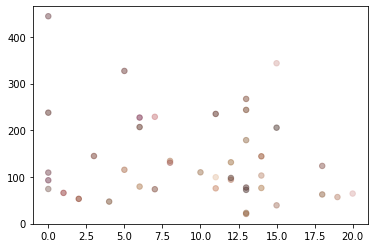

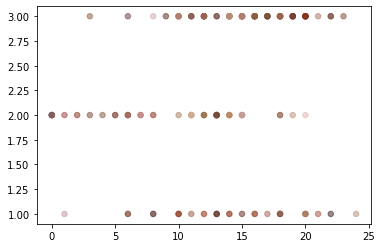

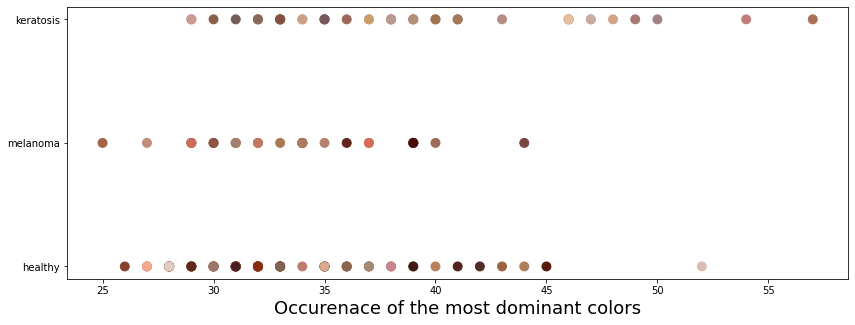

In [182]:
colors=final_df["RGB4html"]
fig, ax = plt.subplots(figsize=(14, 5))
plt.scatter(final_df["RGB4_occ"], 
            final_df["help_int_for_colors"], 
            s=80, 
            c=colors, 
            alpha=1)

#plt.figsize(10,6)
plt.xlabel("Occurenace of the most dominant colors",fontsize=18)
plt.show()

In [ ]:
# Color / Average and dominants / Read out five dominant colors
# For that we should mask the regions
# black area should be deleted somehow

In [169]:
import cv2
import numpy as np
from skimage import io

img = io.imread('../data/example_image/ISIC_0001769.jpg')[:, :, :-1]


In [170]:
average = img.mean(axis=0).mean(axis=0)

In [171]:
pixels = np.float32(img.reshape(-1, 3))

n_colors = 5
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
flags = cv2.KMEANS_RANDOM_CENTERS

_, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
_, counts = np.unique(labels, return_counts=True)

In [173]:
dominant_rgb = palette[np.argmax(counts)]
print(dominant_rgb)
print(average)

[185.85397 149.24878 185.84837]
[172.25146808 145.80666851]


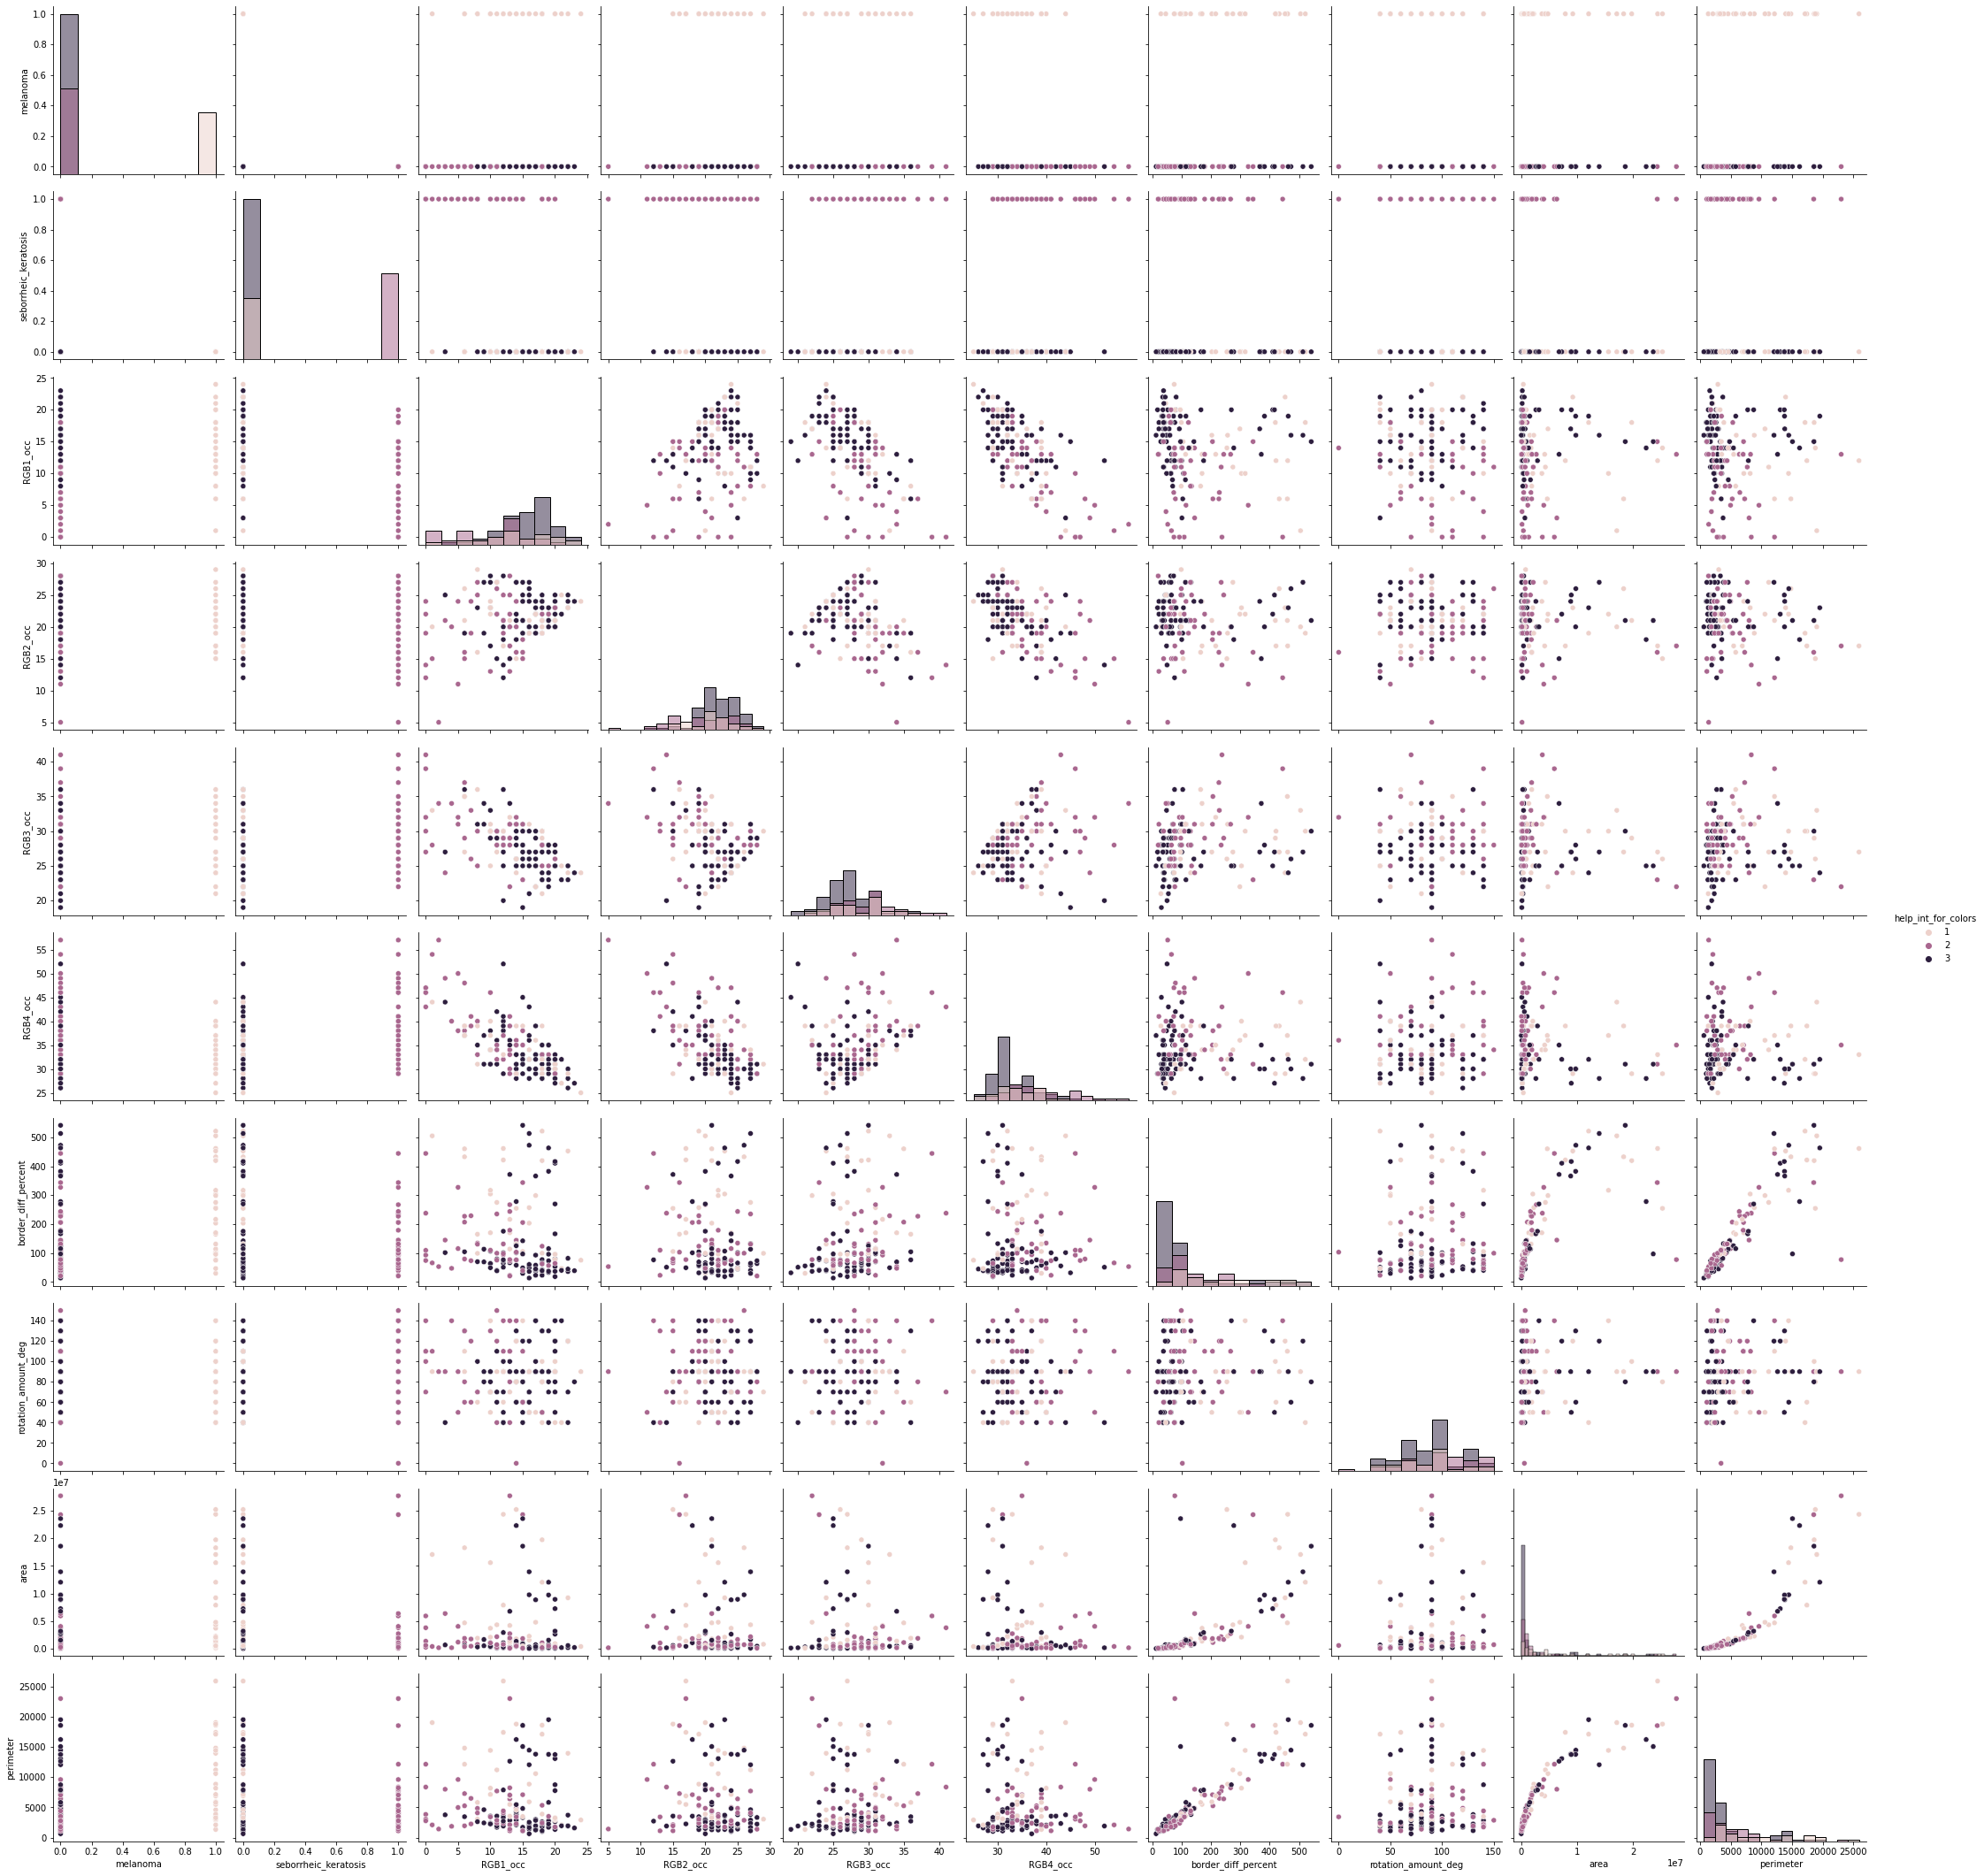

In [173]:
sns.pairplot(final_df, hue="help_int_for_colors",  height=3, diag_kind="hist");

# below code needs a time

In [15]:
features_area = np.empty([num_images,1])
features_area[:] = np.nan

features_perimeter = np.empty([num_images,1])
features_perimeter[:] = np.nan

for i in np.arange(num_images):
    
    # Define filenames related to this image
    file_image = image + os.sep + image_id[i] + '.jpg'
    file_mask = segmentation + os.sep + image_id[i] + '_segmentation.png'
    
    # Read the images with these filenames
    im = plt.imread(file_image)
    mask = plt.imread(file_mask)
    
    # Measure features
    a, p = util.measure_area_perimeter(mask)
    
    # Store in the variables we created before
    features_area[i,0] = a
    features_perimeter[i,0] = p;

In [1]:
print(len(features_perimeter))
print(feature_area)

NameError: name 'features_perimeter' is not defined

In [ ]:
im = plt.imread('fyp2021p3/data/example_image/ISIC_0001769.jpg')
mask=plt.imread('fyp2021p3/data/example_segmentation/ISIC_0001769_segmentation.png')

In [35]:
# Task 2
# - What do you expect from these values for a perfect circle?

# Load csv file, get filenames for 

picTypes = pd.read_csv("../data/example_ground_truth.csv", sep = ",")
#display(picTypes)

mask = picTypes["seborrheic_keratosis"] == 1
keratosis = picTypes[mask]

#display(keratosis)
keratosis_files = keratosis["image_id"].sort_values()

display(keratosis_files)

29     ISIC_0012143
35     ISIC_0012204
37     ISIC_0012210
40     ISIC_0012254
47     ISIC_0012380
48     ISIC_0012383
50     ISIC_0012417
52     ISIC_0012492
53     ISIC_0012513
58     ISIC_0012720
61     ISIC_0012927
63     ISIC_0012959
68     ISIC_0013127
72     ISIC_0013215
74     ISIC_0013421
82     ISIC_0013632
83     ISIC_0013637
91     ISIC_0013863
93     ISIC_0013945
95     ISIC_0014038
96     ISIC_0014055
97     ISIC_0014139
101    ISIC_0014212
104    ISIC_0014310
105    ISIC_0014382
108    ISIC_0014568
109    ISIC_0014572
110    ISIC_0014597
111    ISIC_0014601
112    ISIC_0014608
113    ISIC_0014610
114    ISIC_0014611
115    ISIC_0014616
116    ISIC_0014618
117    ISIC_0014620
118    ISIC_0014623
119    ISIC_0014624
120    ISIC_0014633
121    ISIC_0014635
122    ISIC_0014637
124    ISIC_0014712
136    ISIC_0015062
Name: image_id, dtype: object

In [55]:
# read-in file names from dummy dataset
path = '../data/example_image/dummy/'
keratosis_dummy_files = [f for f in listdir(path) if isfile(join(path, f))]

for i in keratosis_dummy_files:
    print(i)
    im = plt.imread('../data/example_image/dummy/'+i)
    filename_size = len(i)
    # Slice string to remove last 3 characters from string
    filename_for_png = i[:filename_size - 4]
    #print(filename_for_png)
    mask=plt.imread('../data/example_segmentation/'+filename_for_png+'_segmentation.png')
    #plt.imshow(mask, cmap='gray')
    #imshow(mask)
    #print(mask)
    #struct_el = morphology.disk(20)
    #print(struct_el)
    #mask_eroded = morphology.binary_erosion(mask, struct_el)
    #plt.imshow(image_perimeter, cmap='gray') #The perimeter is very thin so it might be difficult to see on the screen
    #print(np.sum(image_perimeter))
    
    
    

'''    filename = '../data/example_segmentation/'+filename_for_png+'_segmentation.png'
    I = imread(filename)
    imshow(I)
    show()
    time.sleep(0.01)'''
    

ISIC_0012204.jpg


NameError: name 'imread' is not defined

3.545708406819518


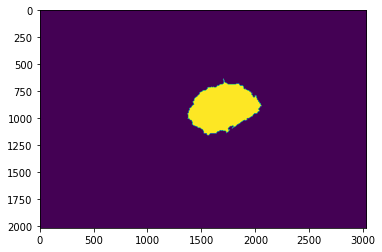

In [2]:
#Total size of the image
total = mask.shape[0] * mask.shape[1] 

#Size of mask only
area = np.sum(mask)

#As percentage
print(area/total*100)

plt.imshow(mask)


In [ ]:
for i in 

In [3]:
# A way to measure width/height 

pixels_in_col = np.max(np.sum(mask, axis=0))
# pixels_in_row = 

print(pixels_in_col)

469.0


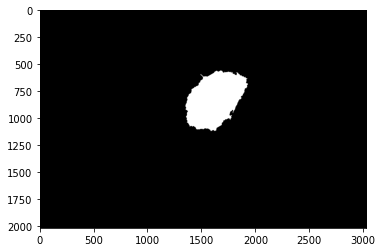

In [4]:
# Diameter at an angle

from skimage import transform

rot_im = transform.rotate(mask, 30)
plt.imshow(rot_im, cmap='gray')


In [6]:
#Structural element, that we will use as a "brush" on our mask
struct_el = morphology.disk(20)

print(struct_el)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


216160.0
177421


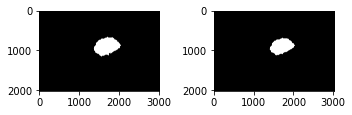

In [7]:
mask_eroded = morphology.binary_erosion(mask, struct_el)

# Show side by side

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(mask, cmap='gray')
axes[1].imshow(mask_eroded, cmap='gray')
fig.tight_layout()

# Verify it's smaller
print(area)
print(np.sum(mask_eroded))

38739.0


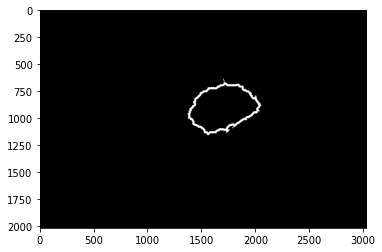

In [8]:
# Subtract the two masks from each other to get the border/perimeter

image_perimeter = mask - mask_eroded

plt.imshow(image_perimeter, cmap='gray') #The perimeter is very thin so it might be difficult to see on the screen

#What is the length? 
print(np.sum(image_perimeter))


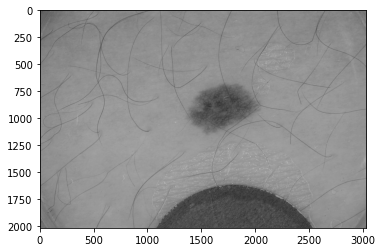

In [9]:
# Work with color image as grayscale

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

gray = rgb2gray(im)
plt.imshow(gray, cmap='gray')



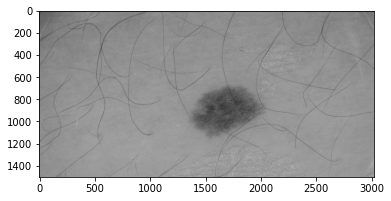

In [10]:
# Let's get rid of the marker
gray2 = gray[0:1500,:]
plt.imshow(gray2, cmap='gray')

mask2 = mask[0:1500,:]


(array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([ 30.8587 ,  53.08448,  75.31026,  97.53604, 119.76182, 141.9876 ,
        164.21338, 186.43916, 208.66494, 230.89072, 253.1165 ]),
 <a list of 3024 BarContainer objects>)

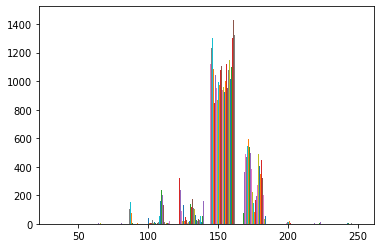

In [11]:
#Look at intensities of image
plt.hist(gray2)


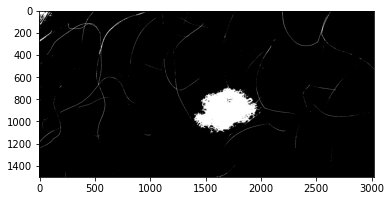

In [12]:
# Threshold
mymask = gray2 < 120  #Pixels with lower intensities will be equal to 1 in the mask
plt.imshow(mymask, cmap='gray')

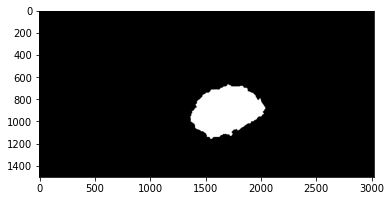

In [14]:
# Opening = first EROSION, then DILATION 

# Erosion will get rid of hairs but also make the lesion smaller. 
# Dilation will restore the lesion (but not the hairs)

struct_el = morphology.disk(5)
opened = opening(mask2, struct_el)

plt.imshow(opened, cmap='gray')

# Filtering 

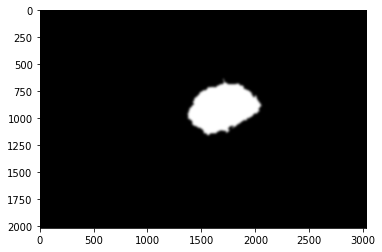

In [16]:
# Gaussian filtering (blur)



blurred = filters.gaussian(mask,sigma=10)

plt.imshow(blurred, cmap='gray')

#What kind of values are in the image now?


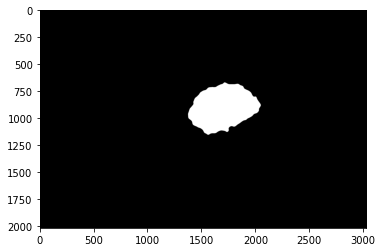

In [17]:
# Threshold again

mask2 = blurred > 0.5
plt.imshow(mask2, cmap='gray')


<ipython-input-18-5012c18a01c6>:3: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  blurred = filters.gaussian(im,sigma=25)


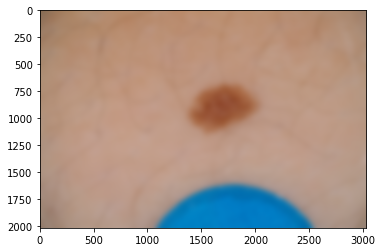

In [18]:
# Blur color image - this could be useful for measuring color (variability)

blurred = filters.gaussian(im,sigma=25)

plt.imshow(blurred)


# General purpose features

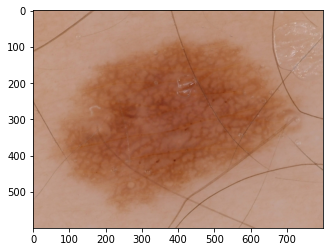

In [19]:
# Many examples in https://scikit-image.org/docs/dev/api/skimage.feature.html 

# Crop image first

im2 = im[600:1200,1300:2100,:]
mask2 = mask[600:1200,1300:2100]


plt.imshow(im2)

In [20]:
# Gaussian features recently available (might need to update version)

# Example segmentation for microscopy image: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_trainable_segmentation.html#sphx-glr-auto-examples-segmentation-plot-trainable-segmentation-py 

!pip install scikit-image==0.18.0

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Python38\\Lib\\site-packages\\~kimage\\draw\\_draw.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.1
    Uninstalling scikit-image-0.18.1:
      Successfully uninstalled scikit-image-0.18.1


In [22]:
from skimage import feature

#Extract feature images
feat_im = feature.multiscale_basic_features(im2, multichannel=True, intensity=False, edges=False, texture=True, sigma_min = 2, sigma_max = 8)
print(feat_im.shape)


(600, 800, 18)


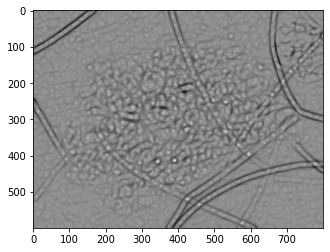

In [23]:
plt.imshow(feat_im[:,:,3], cmap='gray')

[    18     28     68   1439  23403 278645 114794  40245  10357   3980
   2513   2093   1317    684    331     85]


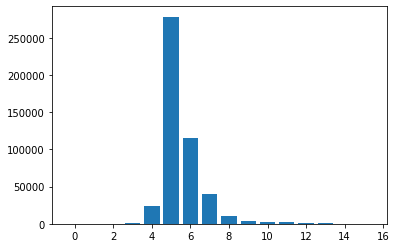

In [24]:
# We measured X features for every pixel in the image - this is good for segmentation, but not image classification yet

# For classification we need to aggregate the outputs for each feature type into one vector

feat_vec, bin_edges = np.histogram(feat_im[:,:,8], bins=16)

plt.bar(np.arange(0,16), feat_vec)
print(feat_vec)

In [25]:
# Determine bins based on intensities instead... 
# plt.hist(feat_im[:,:,8], bins='auto')     # Very slow for large images

flat_im = np.ndarray.flatten(feat_im[:,:,8])
flat_mask = np.ndarray.flatten(mask2)

# Only pixels inside the mask
flat_im = flat_im[flat_mask==1]

quantile_bins = np.quantile(flat_im, np.arange(0,1,0.1))

# Bins have different widths
print(quantile_bins)

#feat_vec, bin_edges = np.histogram(flat_im, bins=quantile_bins)
#print(feat_vec)

[-2.25799321e-03 -1.79941891e-04 -3.98410368e-05  6.71384427e-05
  1.67993980e-04  2.69408338e-04  3.78055521e-04  5.00637846e-04
  6.43923320e-04  8.56541615e-04]
